**INFO 2950 Final Project**

*generic intro about the impact of COVID-19*

*TO DO make this intro way more polished once you have a better idea of what you're doing*

The coronavirus pandemic has drastically changed the lives of Americans. Many adults have lost their jobs or are working remotely. Children are having to learn online. And many essential workers are feeling pressure of working on the front lines during this crisis.

How this may have long term effects on communities and vulnerable populations remains to be seen. My goal is to use 3 datasets to try to identify at-risk areas. 

First, we have the New York Times coronavirus data, which is provides data on the spread of coronavirus. Each day, it updates county data about coronavirus cases and deaths.

Next, we have 

* single parent households with children
* crowded households
* households that speak english less than well.
* ep_age17 percentage aged 17 or younger

* increases in covid cases
* usda atlas of rural america

**DATA DESCRIPTION**

What are the observations (rows) and the attributes (columns)?
* Data set "covid" 1 is of coronavirus cases and deaths by county
* Data set 2 "svi" is the Social Vulnerability index, which provides county data about population vulnerability based on measurements of a variety of factors. These factors are categorized by "socioeconomic status", "household composition & disability", "minority status & languge", and "housing type and transportation." A very large amount of measurements are included on this
* Data set three "unemp" is county economic data. It includes measures such as the rurality of the county, employment rates, median income, and median income relative to the rest of the state.
* I joined these datasets based on the FIPs county code. "svi" and "unemp" had a very large number of attributes, so while joining, I tried to filter the ones I thought would be most salient to this project. I will outline the attributes of the final table below:

# TODO

Why was this dataset created?

Who funded the creation of the dataset?
* "covid" data is created and funded by the New York Times.
* "svi" data is created and funded by the government, specifically the Center for Disease Control (CDC) and Agency for Toxic Substances and Disease Registry (ATSDR)
* "unemp" data is created and funded by the US Economic Research Service

What processes might have influenced what data was observed and recorded and what was not?

What preprocessing was done, and how did the data come to be in the form that you are using?

If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?

Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box).

* "covid" : https://github.com/nytimes/covid-19-data
* "svi": https://svi.cdc.gov/data-and-tools-download.html
* "unemp": https://www.ers.usda.gov/data-products/county-level-data-sets/ 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

First, we'll start by importing the New York Times covid data. I made an additional column that equates to the # days after the first US co-vid case for each entry, to make graphing by date easier. 

In [2]:
covid = pd.read_csv('covid.csv')
covid.rename(columns={'fips':'FIPS'}, inplace=True)

covid['date'] = pd.to_datetime(covid["date"])
start_date = pd.Timestamp("2020-01-21")
covid["daysafter"] = (covid["date"] - start_date).dt.days

covid.head()

,date,county,state,FIPS,cases,deaths,daysafter
0,2020-01-21,Snohomish,Washington,53061.0,1,0,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0,1
2,2020-01-23,Snohomish,Washington,53061.0,1,0,2
3,2020-01-24,Cook,Illinois,17031.0,1,0,3
4,2020-01-24,Snohomish,Washington,53061.0,1,0,3


Next I'll import the social vulnerability index data. This is a really large data set, so I'm immediately filtering out the relevant columns into a more manageable data set.

In [3]:
svi = pd.read_csv('svi-2018.csv')
svi['FIPS'] = svi['FIPS'].astype(float)

svi.head()

socialvuln = svi.filter(items = ['ST', 'COUNTY', 'FIPS', 'AREA_SQMI', 'E_TOTPOP',])

socialvuln.head()

,ST,COUNTY,FIPS,AREA_SQMI,E_TOTPOP
0,35,Rio Arriba,35039.0,5860.869195,39307
1,1,Autauga,1001.0,594.443459,55200
2,1,Blount,1009.0,644.830460,57645
3,1,Butler,1013.0,776.838201,20025
4,1,Coffee,1031.0,678.985821,51288


Next I'm importing the economic/unemployment data. Once again, I filter it out into a more manageable set, only taking the columns I'm interested in.

In [4]:
unemp = pd.read_csv('unemployment.csv')

unemp['FIPS'] = unemp['FIPS'].astype(float)
unemp.head()

unemployment = unemp.filter(items=['FIPS', 'State', 'Area_name', 'Rural_urban_continuum_code_2013',
                    'Urban_influence_code_2013', 'Metro_2013', 'Civilian_labor_force_2018',
                    'Employed_2018', 'Unemployed_2018', 'Unemployment_rate_2018', 
                    'Median_Household_Income_2018', 'Med_HH_Income_Percent_of_State_Total_2018'])

unemployment.head()


,FIPS,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,0.0,US,United States,NaN,NaN,NaN,"161,640,488","155,344,043","6,296,445",3.9,"$61,937",NaN
1,1000.0,AL,Alabama,NaN,NaN,NaN,"2,198,837","2,112,347","86,490",3.9,"$49,881",100.0
2,1001.0,AL,"Autauga County, AL",2.0,2.0,1.0,"25,957","25,015",942,3.6,"$59,338",119.0
3,1003.0,AL,"Baldwin County, AL",3.0,2.0,1.0,"93,849","90,456","3,393",3.6,"$57,588",115.5
4,1005.0,AL,"Barbour County, AL",6.0,6.0,0.0,"8,373","7,940",433,5.2,"$34,382",68.9


Here I merge my unemployment and economic data on FIPs, which is a standardized numerical code for US counties.

In [21]:
merge1 = pd.merge(unemployment, covid, on='FIPS')

merge1['Civilian_labor_force_2018'] = merge1['Civilian_labor_force_2018'].str.replace(',', '').astype(int)
merge1['Employed_2018'] = merge1['Employed_2018'].str.replace(',', '').astype(int)
merge1['Unemployed_2018'] = merge1['Unemployed_2018'].str.replace(',', '').astype(int)
merge1['Median_Household_Income_2018'] = merge1['Median_Household_Income_2018'].str.replace(',', '')
merge1['Median_Household_Income_2018'] = merge1['Median_Household_Income_2018'].str.replace('$', '').astype(int)

merge1 = merge1.assign(cases_per_labor_force = merge1['cases']/merge1['Civilian_labor_force_2018'])



merge1.tail()

,FIPS,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,date,county,state,cases,deaths,daysafter,cases_per_labor_force
91465,56043.0,WY,"Washakie County, WY",7.0,11.0,0.0,4058,3886,172,4.2,55190,88.6,2020-04-22,Washakie,Wyoming,4,0,92,0.000986
91466,56043.0,WY,"Washakie County, WY",7.0,11.0,0.0,4058,3886,172,4.2,55190,88.6,2020-04-23,Washakie,Wyoming,4,0,93,0.000986
91467,56043.0,WY,"Washakie County, WY",7.0,11.0,0.0,4058,3886,172,4.2,55190,88.6,2020-04-24,Washakie,Wyoming,4,0,94,0.000986
91468,56043.0,WY,"Washakie County, WY",7.0,11.0,0.0,4058,3886,172,4.2,55190,88.6,2020-04-25,Washakie,Wyoming,4,0,95,0.000986
91469,56043.0,WY,"Washakie County, WY",7.0,11.0,0.0,4058,3886,172,4.2,55190,88.6,2020-04-26,Washakie,Wyoming,4,0,96,0.000986


If we are not mapping the change in COVID over time, it will be easiest to look at the data just using the most recent day. I create the latest_date data subset for this. To check this, I display a model of COVID cases and deaths. It looks pretty much how we might expect it to. There seem to be a few outliers where death rate is much higher or lower than what we expected. We can look at these more closely later.

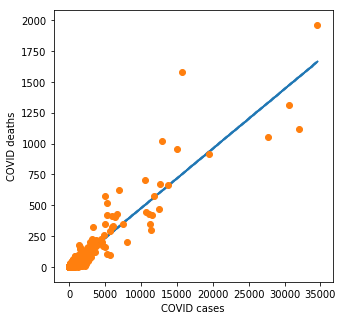

Model slope:      0.04831589787875697
Model intercept:  -0.3998831821380797


In [22]:
latest_date = merge1[merge1['date']=='2020-04-26']

cases_vs_deaths = LinearRegression(fit_intercept=True)
cases_vs_deaths.fit(latest_date[['cases']], latest_date['deaths'])
xfit = np.linspace(0, latest_date['cases'].max(),1000)
yfit = cases_vs_deaths.predict(xfit[:,np.newaxis])
                            

plt.figure(figsize=(5,5))
plt.scatter(xfit,yfit,s=.5)
plt.scatter(latest_date['cases'], latest_date['deaths'])

plt.xlabel('COVID cases')
plt.ylabel('COVID deaths')
plt.show()

print("Model slope:     ", cases_vs_deaths.coef_[0])
print("Model intercept: ", cases_vs_deaths.intercept_)

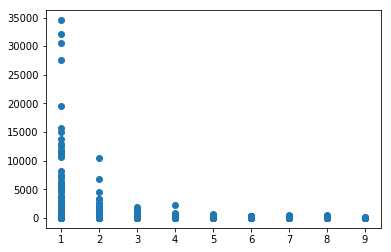

In [23]:
plt.scatter(latest_date['Rural_urban_continuum_code_2013'], latest_date['cases'])
plt.show()

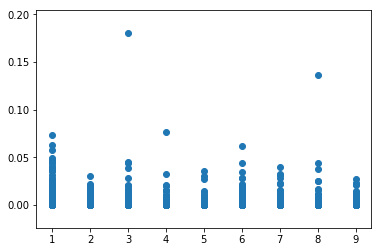

In [24]:
plt.scatter(latest_date['Rural_urban_continuum_code_2013'], latest_date['cases']/latest_date['Civilian_labor_force_2018'])
plt.show()

In [44]:
model1 = LinearRegression(fit_intercept=True)

model1.fit(latest_date[['Rural_urban_continuum_code_2013', 'Urban_influence_code_2013']], latest_date['cases_per_labor_force'])

# print('rur-urb-cont  urban-influence')
# print(model1.coef_)

print('r^2 of rural urban continuum and case per capita at most recent date: ', np.corrcoef(latest_date['Rural_urban_continuum_code_2013'], latest_date['cases_per_labor_force'])[0,1])
print('r^2 of urban influence and case per capita at most recent date:       ', np.corrcoef(latest_date['Urban_influence_code_2013'], latest_date['cases_per_labor_force'])[0,1])


r^2 of rural urban continuum and case per capita at most recent date:  -0.09347133141785299
r^2 of urban influence and case per capita at most recent date:        -0.09664024210950428


It seems like at this point, because the virus is widespread, the rural urban contiuum and the urban influence doesn't have any significant correlation with the extent of the outbreak in each county. But there are a few huge outliers in terms of the case per labor force. Let's look at where those are.

In [25]:
latest_date.sort_values(by='cases_per_labor_force', ascending=False).head()

,FIPS,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,date,county,state,cases,deaths,daysafter,cases_per_labor_force
4550,5079.0,AR,"Lincoln County, AR",3.0,2.0,1.0,4041,3867,174,4.3,44951,95.4,2020-04-26,Lincoln,Arkansas,727,0,96,0.179906
71529,47007.0,TN,"Bledsoe County, TN",8.0,7.0,0.0,4303,4053,250,5.8,40195,76.8,2020-04-26,Bledsoe,Tennessee,588,0,96,0.136649
61541,39101.0,OH,"Marion County, OH",4.0,3.0,0.0,28395,27139,1256,4.4,45419,80.9,2020-04-26,Marion,Ohio,2178,4,96,0.076704
54941,36087.0,NY,"Rockland County, NY",1.0,1.0,1.0,154676,148901,5775,3.7,88960,131.5,2020-04-26,Rockland,New York,11256,349,96,0.072771
61946,39129.0,OH,"Pickaway County, OH",1.0,1.0,1.0,26268,25145,1123,4.3,58742,104.6,2020-04-26,Pickaway,Ohio,1658,5,96,0.063119


Coming in fourth in cases per labor force is Rockland County in New York. Not surprising considering this county is just north of New York City, which is pretty much the epicenter of the outbreak. Let's look at the growth rate of the disease in the county.

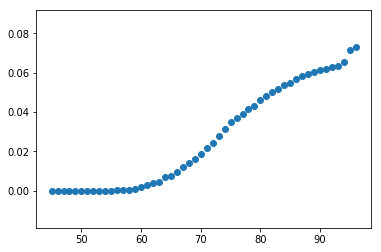

In [52]:
rockland_county = merge1[ merge1['FIPS'] == 36087.0]

plt.scatter(rockland_county['daysafter'], rockland_county['cases']/rockland_county['Civilian_labor_force_2018'])
plt.show()

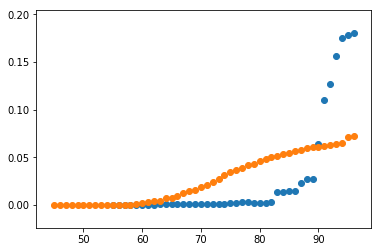

In [53]:
lincoln_county = merge1[ merge1['FIPS'] == 5079.0]

plt.scatter(lincoln_county['daysafter'], lincoln_county['cases']/lincoln_county['Civilian_labor_force_2018'])
plt.scatter(rockland_county['daysafter'], rockland_county['cases']/rockland_county['Civilian_labor_force_2018'])
plt.show()

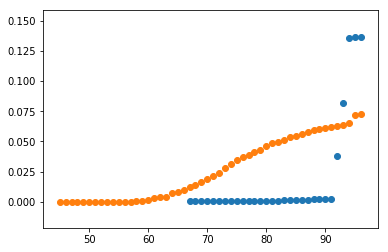

In [54]:
blesdoe_county = merge1[ merge1['FIPS'] == 47007.0]

plt.scatter(blesdoe_county['daysafter'], blesdoe_county['cases']/blesdoe_county['Civilian_labor_force_2018'])
plt.scatter(rockland_county['daysafter'], rockland_county['cases']/rockland_county['Civilian_labor_force_2018'])
plt.show()


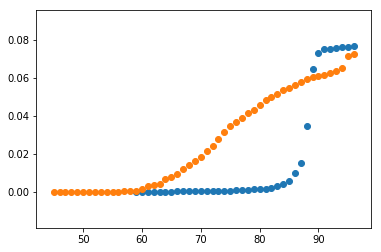

In [55]:
marion_county = merge1[ merge1['FIPS'] == 39101.0]

plt.scatter(marion_county['daysafter'], marion_county['cases']/marion_county['Civilian_labor_force_2018'])
plt.scatter(rockland_county['daysafter'], rockland_county['cases']/rockland_county['Civilian_labor_force_2018'])
plt.show()